In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import random
import matplotlib.pylab as plt
import tensorflow as tf
%matplotlib inline

def show_gray(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()
    
def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [2]:
from keras.utils import Sequence
import imgaug as ia
from imgaug import augmenters as iaa

annotations = json.load(open('annotations.json'))
random.seed(666)
random.shuffle(annotations)
an_train, an_val = annotations[:800], annotations[800:]

class train_generator(Sequence):
    def __init__(self, annotations, size, batch_size=25):
        self.size = size
        self.batch_size = batch_size
        self.img_path = '../humpback-whale-identification/data/train/'
        self.annotations = annotations
        random.shuffle(self.annotations)
        
        self.seq = iaa.Sequential([
            iaa.Multiply((1, 2)), # change brightness, doesn't affect keypoints
            iaa.Affine(
                rotate=(0, 15),
                scale=(0.6, 1.2),
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
            ), # rotate by exactly 15deg and scale to 10-20%, affects keypoints
            iaa.Fliplr(0.5),
            iaa.Dropout(p=(0, 0.1)),
            iaa.AdditiveGaussianNoise(scale=0.1*255)
        ])       

#         self.seq = iaa.Sequential([
#             iaa.Multiply((1, 2)), # change brightness, doesn't affect keypoints
# #             iaa.Affine(
# #                 rotate=(0, 5),
# #                 scale=(0.95, 1.05),
# #                 translate_percent={"x": (-0.03, 0.03), "y": (-0.03, 0.03)}
# #             ), # rotate by exactly 15deg and scale to 10-20%, affects keypoints
#             iaa.Fliplr(0.5)
#             #iaa.Dropout(p=(0, 0.1)),
#             #iaa.AdditiveGaussianNoise(scale=0.1*255)
#         ])  

    def __len__(self):
        return int(np.ceil(len(self.annotations) / float(self.batch_size)))

    def __getitem__(self, idx):
        seq_det = self.seq.to_deterministic()
        batch_an = self.annotations[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        batch_imgs, bboxes = [], []
        for an in batch_an:
            img = cv2.imread(self.img_path + an['filename'])
            h, w, _ = img.shape           
            
            an = list(filter(lambda x: x['class'] == 'fluke', an['annotations']))[0]

            img = seq_det.augment_images([img])[0]
            keypoints = ia.KeypointsOnImage([ia.Keypoint(x=an['x'], y=an['y']), 
                                             ia.Keypoint(x=an['x'] + an['width'], y=an['y'] + an['height'])],
                                            shape=img.shape)            
            keypoints = seq_det.augment_keypoints([keypoints])[0]
            tl, br = keypoints.keypoints[0], keypoints.keypoints[1]
            
#             bboxes.append([np.clip(tl.y, 0, h),
#                            np.clip(tl.x, 0, w),
#                            np.clip(br.y, 0, h),
#                            np.clip(br.x, 0, w)])            
            
            bboxes.append([np.clip(tl.y, 0, h) / h,
                           np.clip(tl.x, 0, w) / w,
                           np.clip(br.y, 0, h) / h,
                           np.clip(br.x, 0, w) / w])

            batch_imgs.append(cv2.resize(img, (self.size, self.size)))
        
        return np.array(batch_imgs)/255., np.array(bboxes)

    def on_epoch_end(self):
        random.shuffle(self.annotations)

Using TensorFlow backend.


In [3]:
size = 299
batch_size = 10
gen = train_generator(an_train, size, batch_size)

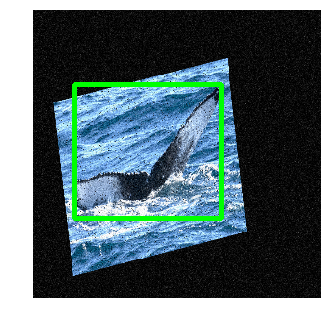

array([[0.2533394 , 0.62113032, 0.76075233, 0.14635149],
       [0.3668955 , 0.68576514, 0.80149063, 0.137313  ],
       [0.32283368, 0.69169345, 0.77835698, 0.12532328],
       [0.08360618, 0.69025079, 0.99810095, 0.12886038],
       [0.16044783, 0.66774497, 0.94403421, 0.14903946],
       [0.25983867, 0.6544249 , 0.72405115, 0.14550714],
       [0.13098601, 0.68266035, 0.95491936, 0.12611968],
       [0.22571461, 0.69004619, 0.92400756, 0.1288133 ],
       [0.28904857, 0.69385921, 0.88549446, 0.13014346],
       [0.18156379, 0.6216607 , 0.89801311, 0.22001586]])

In [4]:
it = gen.__getitem__(1)

img_ind = 5
img = (it[0][img_ind]*255).astype('uint8')
h, w, _ = img.shape
bb = it[1][img_ind]
x1, y1, x2, y2 = int(bb[1]*w), int(bb[0]*h), int(bb[3]*w), int(bb[2]*h)
cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
show(img)

it[1]

In [5]:
from keras import applications
from keras.models import Sequential, Model, Input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop, SGD, Adam

def l1_loss(a, b):
    return tf.reduce_mean(tf.reduce_sum(tf.abs(a - b), axis=1))

size = 128
#size = 299
#size = 224
batch_size = 25

def get_val_data(an_val):
    imgs, bboxes = [], []
    for an in an_val:
        img = cv2.imread('../humpback-whale-identification/data/train/' + an['filename'])
        h, w, _ = img.shape           

        an = list(filter(lambda x: x['class'] == 'fluke', an['annotations']))[0]
        bboxes.append([np.clip(an['y'], 0, h) / h,
                       np.clip(an['x'], 0, w) / w,
                       np.clip(an['y'] + an['height'], 0, h) / h,
                       np.clip(an['x'] + an['width'], 0, w) / w])

#         bboxes.append([np.clip(an['y'], 0, h),
#                        np.clip(an['x'], 0, w),
#                        np.clip(an['y'] + an['height'], 0, h),
#                        np.clip(an['x'] + an['width'], 0, w)])

        imgs.append(cv2.resize(img, (size, size)))

    return np.array(imgs)/255., np.array(bboxes)

from keras.layers.convolutional import Conv2D, MaxPooling2D
def build_simple_model(with_dropout=True):
    kwargs     = {'activation':'relu', 'padding':'same'}
    conv_drop  = 0.2
    dense_drop = 0.5
    inp        = Input(shape=(size,size,3))

    x = inp

    x = Conv2D(64, (9, 9), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    #x = Dense(4, activation='linear')(x)
    x = Dense(4, activation='sigmoid')(x)
    return Model(inp,x)

# model = applications.Xception(weights='imagenet', include_top=False, input_shape=(size, size, 3))
# #model = applications.Xception(weights='imagenet', include_top=False, input_shape=(size, size, 3), pooling='avg')
# #model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(size, size, 3))

# head = Sequential()
# head.add(GlobalAveragePooling2D(input_shape = model.output_shape[1:]))
# #head.add(Flatten(input_shape = model.output_shape[1:]))
# #head.add(Dense(2000, activation='relu', input_shape = model.output_shape[1:]))
# head.add(Dropout(0.2))
# head.add(Dense(1000, activation='relu'))
# head.add(Dense(500, activation='relu'))
# head.add(Dense(4, activation='sigmoid'))
# #head.add(Dense(4, activation='linear'))
# #head.add(Dense(4, activation='sigmoid', input_shape = model.output_shape[1:]))

# model = Model(inputs = model.input, outputs = head(model.output))

model = build_simple_model()

# n_xception_layers = len(model.layers)
# for layer in model.layers[:n_xception_layers]:
#     layer.trainable = False
# for layer in model.layers[n_xception_layers:]:
#     layer.trainable = True

x_val, y_val = get_val_data(an_val)

# model.fit_generator(train_generator(an_train, size, batch_size),
#                     epochs = 100,
#                     max_queue_size=4)

for i in range(1, 11):
    model_name = 'cropping-%01d.h5' % i
    print(model_name)
    #model.compile(Adam(lr=0.032), loss=l1_loss)
    model.compile(Adam(lr=0.032), loss='mean_squared_error')
    model.fit_generator(train_generator(an_train, size, batch_size),
                        epochs=50, max_queue_size=4,
                        validation_data=(x_val, y_val),
                        callbacks=[
                            EarlyStopping(monitor='val_loss', patience=9, min_delta=0.1, verbose=1),
                            ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.1, factor=0.25,
                                              min_lr=0.002, verbose=1),
                            ModelCheckpoint(model_name, save_best_only=True, save_weights_only=True),
                        ])
    model.load_weights(model_name)
    model.evaluate(x_val, y_val, verbose=0)

In [152]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 128, 128, 64) 15616       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_35[0][0]                  
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 128, 128, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
dropout_19